### Libraries:

In [150]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper

### Basic Methods:

In [42]:
                                """Regression chart function:"""

def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(),'bo', label='expected', )
    plt.plot(t['pred'].tolist(),'go', label='prediction')
    plt.ylabel('output')
    plt.title('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(pred,y))))
    plt.legend()
    plt.show()

In [43]:
                            """Get required variables from raw data"""

def get_data(data_path, skiprow):
    df = pd.read_excel(data_path, skiprows = skiprow)
    for col in df.columns:
        if not (col in ['x1', 'x2', 'x3', 'x4','x5','x6','x7','y1', 'y2', 'y3', 'y4']):
            df = df.drop(col, axis = 1)
    df1 = df.rename(columns=df.iloc[0]).drop(df.index[0]).drop([1,2], axis=0)
    df1 =df1.reset_index().drop(['index'], axis=1)
    return df1


### Get Data:

In [44]:
df = get_data("/Users/mac/Documents/HiWi-Payen/New_Data/multiplevairbales_data.xlsx", 0)  #provide the address for your data location
df.head(10)

,Nozzle pos.,Inlet duct,Air flow,Air temp.,Feed flow,GLR,Avg. TKE,Mean diameter,Variance,Mean Sphericity,Moisture content
0,2.4,10,200,150,6,0.3,0.0087,125.943,0.748193,0.913,NaN
1,2.4,10,200,200,6,0.3,0.0293,106.58,0.63832,0.909,NaN
2,2.4,10,300,150,6,0.3,0.0448,103.83,0.54482,0.918,NaN
3,2.4,10,300,150,6,0.1,0.0448,265.513,0.905542,0.871,NaN
4,2.4,10,300,200,6,0.3,0.0248,110.166,0.578746,0.886,NaN
5,2.4,10,300,200,6,0.1,0.0248,232.74,0.691293,0.866,NaN
6,2.4,10,300,200,12,0.2,0.0248,124.209,0.663465,0.897,NaN
7,2.4,10,300,200,12,0.0666667,0.0248,254.591,0.755225,0.861,NaN
8,2.4,2,200,150,6,0.3,0.1036,168.657,1.00984,0.871,NaN
9,2.4,2,200,200,6,0.3,0.1047,108.085,0.678292,0.9,NaN


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Nozzle pos.       45 non-null     object
 1   Inlet duct        45 non-null     object
 2   Air flow          45 non-null     object
 3   Air temp.         45 non-null     object
 4   Feed flow         45 non-null     object
 5   GLR               45 non-null     object
 6   Avg. TKE          45 non-null     object
 7   Mean diameter     45 non-null     object
 8   Variance          45 non-null     object
 9   Mean Sphericity   45 non-null     object
 10  Moisture content  17 non-null     object
dtypes: object(11)
memory usage: 4.0+ KB


### Datatype Conversion:

In [140]:
#Change of datatypes of the variable

# Independent variables(INPUT)
df['Nozzle pos.']    = df['Nozzle pos.'].astype('int')         # It's a discrete level variable can be nominal
df['GLR']            = df['GLR'].astype('float')               # It's a float value coz it's a ratio
df['Avg. TKE']       = df['Avg. TKE'].astype('float')          # It's a float variable    
df['Inlet duct']     = df['Inlet duct'].astype('int')          # It's an integer
df['Air flow']       = df['Air flow'].astype('float')          # It's a float variable
df['Air temp.']      = df['Air temp.'].astype('int')           # It's integer         
df['Feed flow']      = df['Feed flow'].astype('float')         # It's always a float

# Dependent variables (OUTPUT)
df['Mean diameter']     = df['Mean diameter'].astype('float')
df['Mean Sphericity']   = df['Mean Sphericity'].astype('float')
df['Variance']          = df['Variance'].astype('float')
df['Moisture content']  = df['Moisture content'].astype('float')

df.dtypes

Nozzle pos.           int64
Inlet duct            int64
Air flow            float64
Air temp.             int64
Feed flow           float64
GLR                 float64
Avg. TKE            float64
Mean diameter       float64
Variance            float64
Mean Sphericity     float64
Moisture content    float64
dtype: object

### Data-Split:

In [664]:
# Datasplit into x(independent) y(dependent) variable
#X:
x = df.drop(['Mean diameter','Variance','Mean Sphericity','Moisture content'], axis=1)

#Y:
multiplier = 1000
y1 = np.round(df['Mean diameter'],2)
y2 = np.round(multiplier* df['Mean Sphericity'],2)
y3 = np.round(multiplier* df['Variance'], 2)
y4 = np.round(df['Moisture content'], 2)

In [665]:
# for individual y values (y1,y2,y3):
x_train, x_test, y_train1, y_test1 = train_test_split  (x,y1,test_size=0.25, random_state=125)
x_train, x_test, y_train2, y_test2 = train_test_split  (x,y2,test_size=0.25, random_state=125)
x_train, x_test, y_train3, y_test3 = train_test_split  (x,y3,test_size=0.25, random_state=125)

### Features Transformation:

In [666]:
# Input variable transformation based on datatype using mapper:

catagorical_features = [c for c in x_train.columns if x_train.dtypes[c] == 'int64']
numerical_features = [n for n in x_train.columns if x_train.dtypes[n] == 'float64' ]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [ MinMaxScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

#fit the transformation to training data
m = mapper.fit(x_train)

#transform the train and test data on the basis of mapper 
x_train = m.transform(x_train)
x_test = m.transform(x_test)

## Predict the Sphericity of the particle sizes distribution: y2

In [667]:
xgb_y2  =  xgb.XGBRegressor(objective ='reg:squarederror',
                          booster = "gbtree",
                          max_depth = 2,
                          colsample_bylevel = 0.8, 
                          subsample = 1,
                          n_estimators = 900,
                          learning_rate = 0.11,
                          min_child_weight = 3,
                          gamma = 2,
                          reg_alpha = 1,
                          reg_lambda = 1,
                          sampling_method = "uniform",
                          importance_type = 'gain',
                          random_state = 3)

In [668]:
xgb_y2.fit(x_train, y_train2)
round(xgb_y2.score(x_test, y_test2)* 100, 2)

73.53

In [669]:
                                """Regression chart function:"""

def chart_regression2(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(),'bo', label='expected', )
    plt.plot(t['pred'].tolist(),'go', label='prediction')
    # add legend and set position to lower right
    
    plt.plot([], [], ' ', label=' rmse  = {}'.format(round( np.sqrt(metrics.mean_squared_error(pred,y)),5)))
    plt.ylim(0.8,1.0)
    plt.ylabel('output')
    plt.title('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(pred,y))))
    plt.legend(loc = 'upper left')
    plt.grid(False)
    plt.show()

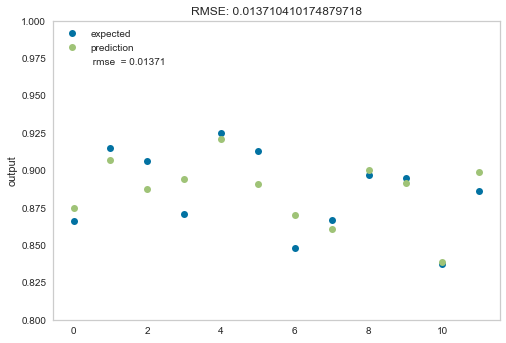

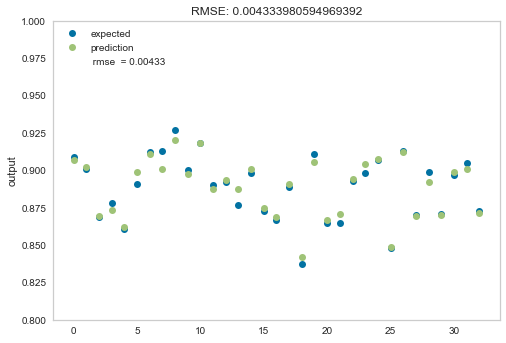

In [670]:
chart_regression2(pred = np.true_divide(xgb_y2.predict(x_test),multiplier) , y= np.true_divide(y_test2, multiplier), sort=False)
chart_regression2(pred = np.true_divide(xgb_y2.predict(x_train), multiplier), y= np.true_divide(y_train2, multiplier), sort=False)

## Predict the Variance of the particle sizes distribution: y3

In [671]:
xgb_y3  =  xgb.XGBRegressor(objective ='reg:squarederror',
                          booster = "gbtree",
                          max_depth = 2,
                          colsample_bylevel = 0.6, 
                          subsample = 1,
                          n_estimators = 600,
                          learning_rate = 0.22,
                          min_child_weight = 5,
                          gamma = 2,
                          reg_alpha = 3,
                          reg_lambda = 3,
                          sampling_method = "uniform",
                          importance_type = 'gain',
                          random_state = 3)

In [672]:
xgb_y3.fit(x_train, y_train3)
round(xgb_y3.score(x_test, y_test3)* 100, 2)

40.18

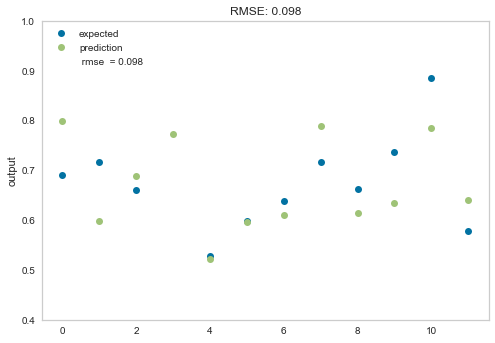

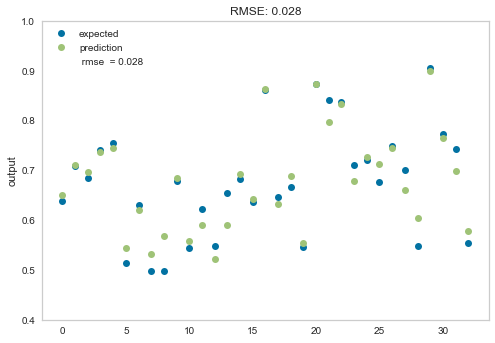

In [673]:
                                """Regression chart function:"""

def chart_regression3(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(),'bo', label='expected', )
    plt.plot(t['pred'].tolist(),'go', label='prediction')
    # add legend and set position to lower right
    
    plt.plot([], [], ' ', label=' rmse  = {}'.format(round( np.sqrt(metrics.mean_squared_error(pred,y)),3)))
    plt.ylim(0.4,1.0)
    plt.ylabel('output')
    plt.title('RMSE: {}'.format(round(np.sqrt(metrics.mean_squared_error(pred,y)),3)))
    plt.legend(loc = 'upper left')
    plt.grid(False)
    plt.show()


chart_regression3(pred = np.true_divide(xgb_y3.predict(x_test),multiplier) , y= np.true_divide(y_test3, multiplier), sort=False)
chart_regression3(pred = np.true_divide(xgb_y3.predict(x_train), multiplier), y= np.true_divide(y_train3, multiplier), sort=False)

## Predict the Variance of the particle sizes distribution: y1

In [674]:
xgb_y1  =  xgb.XGBRegressor(objective ='reg:squarederror',
                          booster = "gbtree",
                          max_depth = 2,
                          colsample_bylevel = 0.7, 
                          subsample = 1,
                          n_estimators = 900,
                          learning_rate = 0.15,
                          min_child_weight = 3,
                          gamma = 2,
                          reg_alpha = 5,
                          reg_lambda = 5,
                          sampling_method = "uniform",
                          importance_type = 'gain',
                          random_state = 3)

In [675]:
xgb_y1.fit(x_train, y_train1)
round(xgb_y1.score(x_test, y_test1)* 100, 2)

91.21

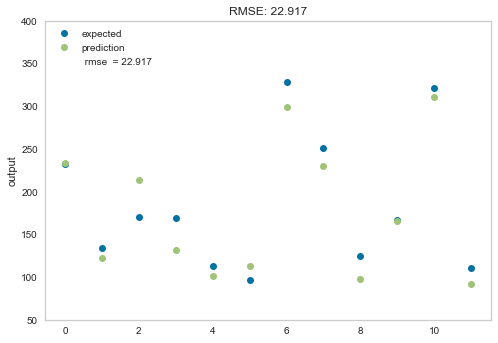

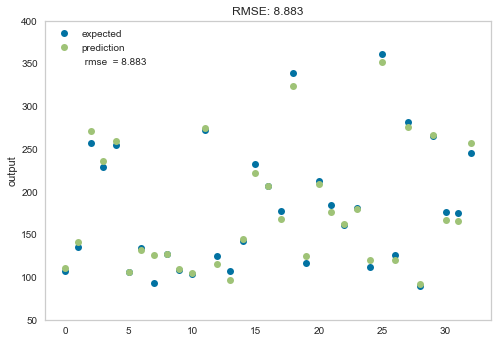

In [680]:
                                """Regression chart function:"""

def chart_regression1(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(),'bo', label='expected', )
    plt.plot(t['pred'].tolist(),'go', label='prediction')
    # add legend and set position to lower right
    
    plt.plot([], [], ' ', label=' rmse  = {}'.format(round( np.sqrt(metrics.mean_squared_error(pred,y)),3)))
    plt.ylim(50,400)
    plt.ylabel('output')
    plt.title('RMSE: {}'.format(round(np.sqrt(metrics.mean_squared_error(pred,y)),3)))
    plt.legend(loc = 'upper left')
    plt.grid(False)
    plt.show()


chart_regression1(pred = np.true_divide(xgb_y1.predict(x_test),1) , y= np.true_divide(y_test1, 1), sort=False)
chart_regression1(pred = np.true_divide(xgb_y1.predict(x_train), 1), y= np.true_divide(y_train1, 1), sort=False)

